In [ ]:
pip install svgwrite


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
pip install cairosvg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
import cairosvg
from sklearn.linear_model import LinearRegression


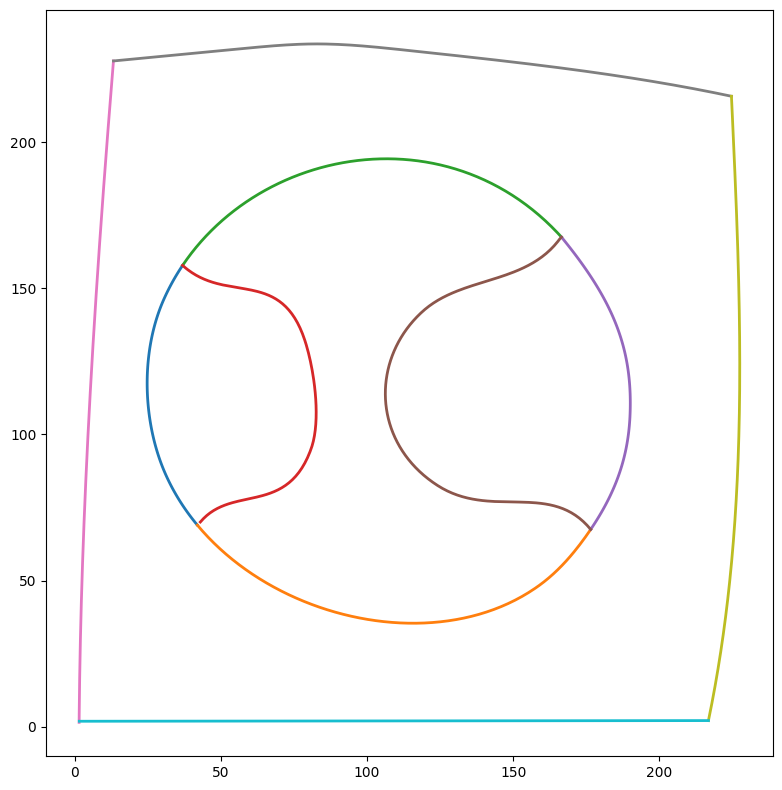

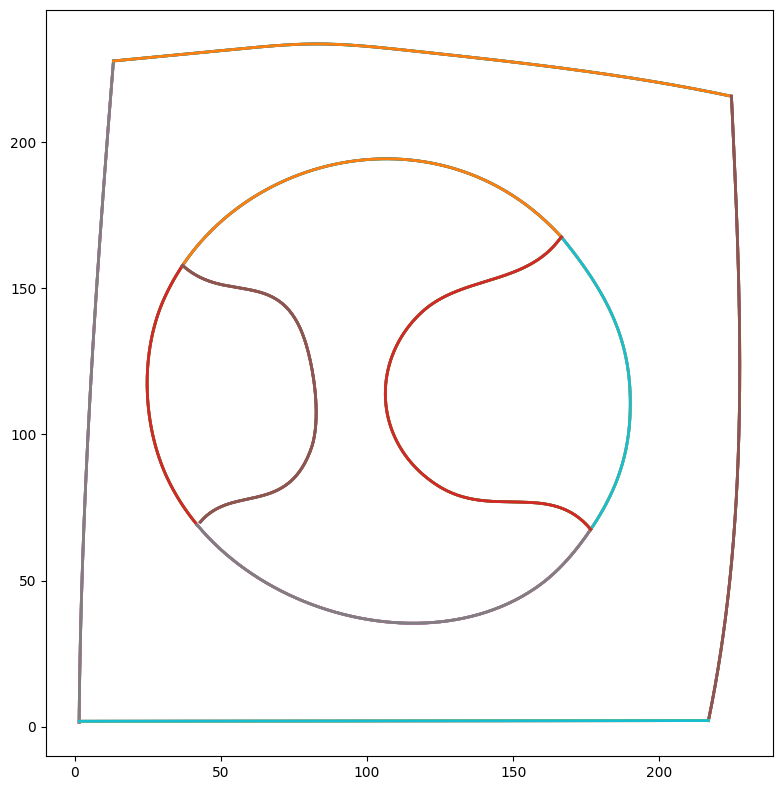

TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
def read_csv(csv_path):
    """
    Reads a CSV file and returns a list of paths, where each path is a list of points.
    Each point is a 2D coordinate (x, y).
    """
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:] # Extract data for the current path
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            # Use npXYs instead of np_path_XYs for indexing
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)

    return path_XYs

def plot(paths_XYs):
    """
    Plots the given paths using matplotlib for visualization.
    """
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)

    ax.set_aspect('equal')
    plt.show()

def is_straight_line(polyline, tolerance=0.01):
    """
    Checks if a polyline is approximately a straight line.
    """
    if len(polyline) <= 2:
        return True

    x = polyline[:, 0].reshape(-1, 1)
    y = polyline[:, 1]
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    error = np.mean((y - y_pred) ** 2)

    return error < tolerance

def regularize_line_to_bezier(polyline):
    """
    Converts a straight line polyline to a cubic Bézier curve.
    """
    p0, p3 = polyline[0], polyline[-1]
    p1 = p0 + (p3 - p0) / 3
    p2 = p3 - (p3 - p0) / 3
    return np.array([p0, p1, p2, p3])

def regularize_shape(polyline):
    """
    Regularizes a polyline by detecting its shape and applying the appropriate transformation.
    """
    if is_straight_line(polyline):
        return regularize_line_to_bezier(polyline)
    else:
        return polyline  # Placeholder for other shapes

def bezier_to_svg(bezier_curves, filename="output.svg"):
    """
    Converts a list of Bézier curves into an SVG file.
    """
    dwg = svgwrite.Drawing(filename, profile='tiny')

    for curve in bezier_curves:
        # Extract individual values from the NumPy array before formatting
        path_data = "M {:.2f},{:.2f} C {:.2f},{:.2f} {:.2f},{:.2f} {:.2f},{:.2f}".format(
            float(curve[0][0]), float(curve[0][1]),
            float(curve[1][0]), float(curve[1][1]),
            float(curve[2][0]), float(curve[2][1]),
            float(curve[3][0]), float(curve[3][1])
        )
        dwg.add(dwg.path(d=path_data, stroke=svgwrite.rgb(10, 10, 16, '%'), fill="none"))

    dwg.save()

# Example usage with a sample file
csv_path = '/content/frag0.csv'  # Replace with the path to your CSV file
paths_XYs = read_csv(csv_path)

# Visualize the original paths
plot(paths_XYs)

# Regularize the paths
regularized_paths = [regularize_shape(polyline) for polyline in paths_XYs]

# Visualize the regularized paths
plot(regularized_paths)

# Save the regularized paths as SVG
bezier_to_svg(regularized_paths, filename="output.svg")

In [ ]:
import numpy as np
from scipy.optimize import least_squares

def fit_circle(points):
    def calc_R(xc, yc):
        return np.sqrt((points[:, 0] - xc)**2 + (points[:, 1] - yc)**2)

    def cost_function(params):
        Ri = calc_R(*params)
        return Ri - Ri.mean()

    center_estimate = np.mean(points, axis=0)
    result = least_squares(cost_function, center_estimate)
    center = result.x
    radius = calc_R(*center).mean()
    return center, radius

def is_circle(points, tolerance=0.01):
    center, radius = fit_circle(points)
    if np.std(np.sqrt((points[:, 0] - center[0])**2 + (points[:, 1] - center[1])**2) - radius) < tolerance:
        return True, center, radius
    return False, None, None

def fit_ellipse(points):
    def ellipse_cost(params):
        xc, yc, a, b, theta = params
        xt = (points[:, 0] - xc) * np.cos(theta) + (points[:, 1] - yc) * np.sin(theta)
        yt = -(points[:, 0] - xc) * np.sin(theta) + (points[:, 1] - yc) * np.cos(theta)
        return ((xt / a)**2 + (yt / b)**2 - 1)

    center_estimate = np.mean(points, axis=0)
    params_estimate = np.array([center_estimate[0], center_estimate[1], np.std(points[:, 0]), np.std(points[:, 1]), 0])
    result = least_squares(ellipse_cost, params_estimate)
    return result.x

def is_ellipse(points, tolerance=0.01):
    xc, yc, a, b, theta = fit_ellipse(points)
    return np.max(np.abs(((points[:, 0] - xc) * np.cos(theta) + (points[:, 1] - yc) * np.sin(theta))**2 / a**2 +
                         (-(points[:, 0] - xc) * np.sin(theta) + (points[:, 1] - yc) * np.cos(theta))**2 / b**2 - 1)) < tolerance

# Example usage:
# points = np.array([...])  # Replace with the polyline points
# circle_detected, center, radius = is_circle(points)
# ellipse_detected = is_ellipse(points)


In [ ]:
def is_rectangle(points, tolerance=0.01):
    if len(points) != 4:
        return False
    angles = []
    for i in range(4):
        v1 = points[i] - points[i-1]
        v2 = points[(i+1) % 4] - points[i]
        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        angles.append(angle)
    return np.allclose(angles, np.pi/2, atol=tolerance)

def is_regular_polygon(points, tolerance=0.01):
    sides = np.linalg.norm(points - np.roll(points, -1, axis=0), axis=1)
    return np.std(sides) < tolerance

# Example usage:
# points = np.array([...])  # Replace with the polyline points
# rectangle_detected = is_rectangle(points)
# polygon_detected = is_regular_polygon(points)


In [ ]:
def find_symmetry_line(points):
    center = np.mean(points, axis=0)
    symmetry_line = None
    min_error = np.inf

    for i in range(len(points)):
        p1, p2 = points[i], points[(i + len(points) // 2) % len(points)]
        line_dir = p2 - p1
        line_normal = np.array([-line_dir[1], line_dir[0]])
        line_normal = line_normal / np.linalg.norm(line_normal)
        projection = np.dot(points - p1, line_normal)
        error = np.std(projection)
        if error < min_error:
            min_error = error
            symmetry_line = (p1, p2)

    return symmetry_line, min_error

# Example usage:
# symmetry_line, error = find_symmetry_line(points)


In [ ]:
def complete_curve(points):
    missing_indices = np.where(np.isnan(points[:, 0]))[0]
    if len(missing_indices) == 0:
        return points

    for idx in missing_indices:
        points[idx] = (points[idx - 1] + points[(idx + 1) % len(points)]) / 2
    return points

# Example usage:
# points_with_gaps = np.array([...])  # Replace with your points array including NaNs
# completed_curve = complete_curve(points_with_gaps)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.spatial import ConvexHull
from scipy.optimize import minimize
from collections import defaultdict

def is_circle(polyline, tolerance=0.01):
    """
    Checks if a polyline forms a circle by comparing distances from the center.
    """
    center = np.mean(polyline, axis=0)
    radii = np.linalg.norm(polyline - center, axis=1)
    return np.std(radii) < tolerance

def is_ellipse(polyline, tolerance=0.01):
    """
    Checks if a polyline forms an ellipse by fitting to an ellipse equation.
    """
    def ellipse_residuals(params, x, y):
        xc, yc, a, b, angle = params
        cos_angle = np.cos(angle)
        sin_angle = np.sin(angle)
        xt = x - xc
        yt = y - yc
        term1 = ((xt * cos_angle + yt * sin_angle) / a) ** 2
        term2 = ((yt * cos_angle - xt * sin_angle) / b) ** 2
        return term1 + term2 - 1

    x = polyline[:, 0]
    y = polyline[:, 1]
    xc, yc = np.mean(x), np.mean(y)
    initial_guess = [xc, yc, np.max(x)-xc, np.max(y)-yc, 0]
    result = minimize(lambda params: np.sum(ellipse_residuals(params, x, y)**2), initial_guess)

    return result.success and result.fun < tolerance

def is_rectangle(polyline, tolerance=0.01):
    """
    Checks if a polyline forms a rectangle using convex hull and angles.
    """
    hull = ConvexHull(polyline)
    if len(hull.vertices) != 4:
        return False
    angles = []
    for i in range(4):
        p1 = polyline[hull.vertices[i-1]]
        p2 = polyline[hull.vertices[i]]
        p3 = polyline[hull.vertices[(i+1) % 4]]
        v1 = p1 - p2
        v2 = p3 - p2
        angle = np.abs(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))
        angles.append(angle)
    return np.std(angles) < tolerance

def shape_detection(polyline):
    """
    Detects and regularizes a shape from a polyline.
    """
    if is_circle(polyline):
        print("Detected Circle")
        return "Circle", regularize_circle_to_bezier(polyline)
    elif is_ellipse(polyline):
        print("Detected Ellipse")
        return "Ellipse", regularize_ellipse_to_bezier(polyline)
    elif is_rectangle(polyline):
        print("Detected Rectangle")
        return "Rectangle", regularize_rectangle_to_bezier(polyline)
    else:
        return "Unknown", polyline

def regularize_circle_to_bezier(polyline):
    """
    Converts a circle polyline to a set of cubic Bézier curves.
    """
    # Calculate center and radius from polyline (assumed evenly spaced points on the circle)
    center = np.mean(polyline, axis=0)
    radius = np.linalg.norm(polyline[0] - center)

    # Approximate a circle using four cubic Bézier curves
    kappa = 0.552284749831  # Approximation constant for circle

    # Define the control points for the four segments
    bezier_curves = []
    for angle in np.linspace(0, 2 * np.pi, 5)[:-1]:
        p0 = center + radius * np.array([np.cos(angle), np.sin(angle)])
        p1 = p0 + kappa * radius * np.array([-np.sin(angle), np.cos(angle)])
        p3 = center + radius * np.array([np.cos(angle + np.pi/2), np.sin(angle + np.pi/2)])
        p2 = p3 + kappa * radius * np.array([np.sin(angle + np.pi/2), -np.cos(angle + np.pi/2)])

        bezier_curves.append(np.array([p0, p1, p2, p3]))

    return bezier_curves


def regularize_ellipse_to_bezier(polyline):
    """
    Converts an ellipse polyline to a set of cubic Bézier curves.
    """
    # Calculate the center, major axis, and minor axis
    center = np.mean(polyline, axis=0)
    major_axis = np.max(polyline[:, 0]) - np.min(polyline[:, 0])
    minor_axis = np.max(polyline[:, 1]) - np.min(polyline[:, 1])

    a, b = major_axis / 2, minor_axis / 2  # Semi-major and semi-minor axes
    kappa = 0.552284749831  # Approximation constant for ellipse

    # Define control points for the four segments
    bezier_curves = []
    for angle in np.linspace(0, 2 * np.pi, 5)[:-1]:
        p0 = center + np.array([a * np.cos(angle), b * np.sin(angle)])
        p1 = p0 + kappa * np.array([-a * np.sin(angle), b * np.cos(angle)])
        p3 = center + np.array([a * np.cos(angle + np.pi/2), b * np.sin(angle + np.pi/2)])
        p2 = p3 + kappa * np.array([a * np.sin(angle + np.pi/2), -b * np.cos(angle + np.pi/2)])

        bezier_curves.append(np.array([p0, p1, p2, p3]))

    return bezier_curves

def regularize_rectangle_to_bezier(polyline):
    """
    Converts a rectangle polyline to a set of cubic Bézier curves.
    """
    bezier_curves = []
    for i in range(len(polyline)):
        p0 = polyline[i]
        p3 = polyline[(i + 1) % len(polyline)]
        # For a straight line, the control points are simply 1/3 and 2/3 along the line
        p1 = p0 + (p3 - p0) / 3
        p2 = p0 + 2 * (p3 - p0) / 3
        bezier_curves.append(np.array([p0, p1, p2, p3]))

    return bezier_curves

# Example usage
polyline = np.array([[0, 0], [1, 1], [2, 0], [1, -1], [0, 0]])  # Example polyline
shape_type, bezier_curves = shape_detection(polyline)


Detected Ellipse
